In [5]:
import torch
from torchvision import datasets, transforms

# Defining a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Downloading and loading the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Downloading and loading the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [6]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [7]:
model = Classifier()

images, labels = next(iter(testloader))
# Getting the class probabilities
ps = torch.exp(model(images))
print(ps.shape)

torch.Size([64, 10])


In [9]:
top_p, top_class = ps.topk(1, dim=1)
print(top_class[:10,:])

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])


In [10]:
equals = top_class == labels.view(*top_class.shape)

In [12]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

#accuracy is low as the network is untrained

Accuracy: 7.8125%


In [13]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        ## Implementing the validation pass and printing out the validation accuracy
        test_loss = 0
        accuracy = 0
        
        # Turning off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.518..  Test Loss: 0.421..  Test Accuracy: 0.848
Epoch: 2/30..  Training Loss: 0.393..  Test Loss: 0.461..  Test Accuracy: 0.828
Epoch: 3/30..  Training Loss: 0.358..  Test Loss: 0.415..  Test Accuracy: 0.853
Epoch: 4/30..  Training Loss: 0.333..  Test Loss: 0.408..  Test Accuracy: 0.860
Epoch: 5/30..  Training Loss: 0.320..  Test Loss: 0.400..  Test Accuracy: 0.865
Epoch: 6/30..  Training Loss: 0.300..  Test Loss: 0.375..  Test Accuracy: 0.869
Epoch: 7/30..  Training Loss: 0.288..  Test Loss: 0.391..  Test Accuracy: 0.870
Epoch: 8/30..  Training Loss: 0.279..  Test Loss: 0.365..  Test Accuracy: 0.876
Epoch: 9/30..  Training Loss: 0.275..  Test Loss: 0.375..  Test Accuracy: 0.878
Epoch: 10/30..  Training Loss: 0.266..  Test Loss: 0.363..  Test Accuracy: 0.875
Epoch: 11/30..  Training Loss: 0.258..  Test Loss: 0.357..  Test Accuracy: 0.877
Epoch: 12/30..  Training Loss: 0.252..  Test Loss: 0.377..  Test Accuracy: 0.879
Epoch: 13/30..  Training Loss: 0.245.

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

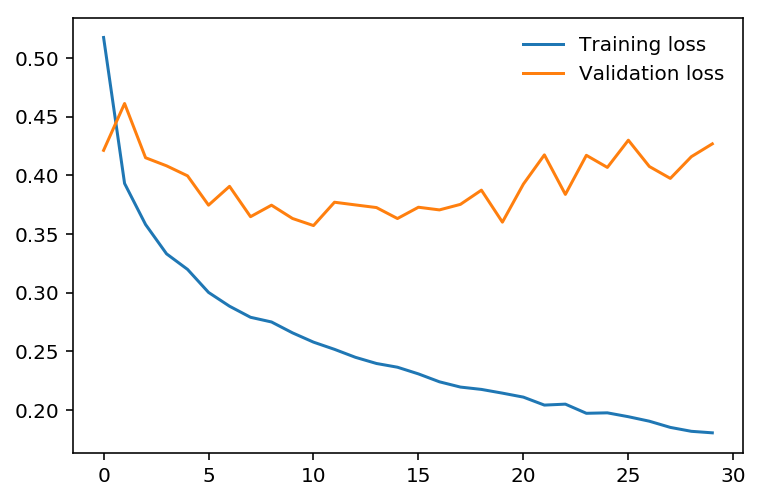

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Above plot shows overfitting. To remove that we will use dropout

In [16]:
## Defining model with dropout
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [17]:
## Training model with dropout, and monitoring the training progress with the validation loss and accuracy
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.618..  Test Loss: 0.452..  Test Accuracy: 0.838
Epoch: 2/30..  Training Loss: 0.488..  Test Loss: 0.440..  Test Accuracy: 0.840
Epoch: 3/30..  Training Loss: 0.453..  Test Loss: 0.415..  Test Accuracy: 0.856
Epoch: 4/30..  Training Loss: 0.436..  Test Loss: 0.427..  Test Accuracy: 0.847
Epoch: 5/30..  Training Loss: 0.424..  Test Loss: 0.408..  Test Accuracy: 0.851
Epoch: 6/30..  Training Loss: 0.413..  Test Loss: 0.408..  Test Accuracy: 0.849
Epoch: 7/30..  Training Loss: 0.410..  Test Loss: 0.401..  Test Accuracy: 0.851
Epoch: 8/30..  Training Loss: 0.407..  Test Loss: 0.399..  Test Accuracy: 0.864
Epoch: 9/30..  Training Loss: 0.398..  Test Loss: 0.395..  Test Accuracy: 0.864
Epoch: 10/30..  Training Loss: 0.396..  Test Loss: 0.402..  Test Accuracy: 0.864
Epoch: 11/30..  Training Loss: 0.388..  Test Loss: 0.397..  Test Accuracy: 0.864
Epoch: 12/30..  Training Loss: 0.381..  Test Loss: 0.397..  Test Accuracy: 0.862
Epoch: 13/30..  Training Loss: 0.384.

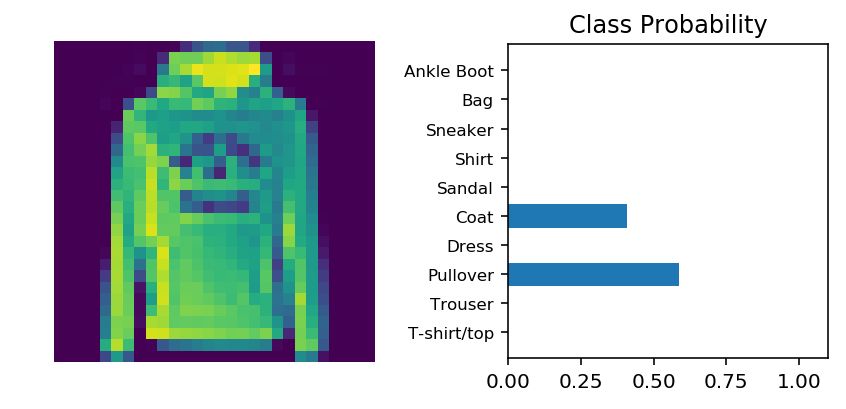

In [18]:
import helper

# Testing network
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

# Converting 2D image to 1D vector
img = img.view(1, 784)

# Calculating the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plotting the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')